In [1]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE129nnn/GSE129798/suppl/GSE129798_Mouse_Adult_DGE_final.tar.gz
!tar -xvf GSE129798_Mouse_Adult_DGE_final.tar.gz
!ls
!mv Mouse_Adult_DGE_final/ kidney

!pip install scanpy
!pip install wandb

--2021-06-08 19:18:26--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE129nnn/GSE129798/suppl/GSE129798_Mouse_Adult_DGE_final.tar.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.7, 2607:f220:41f:250::230, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145094649 (138M) [application/x-gzip]
Saving to: ‘GSE129798_Mouse_Adult_DGE_final.tar.gz.2’

GSE129798_Mouse_Adu 100%[===================>] 138.37M  39.5MB/s    in 4.0s    

2021-06-08 19:18:30 (34.8 MB/s) - ‘GSE129798_Mouse_Adult_DGE_final.tar.gz.2’ saved [145094649/145094649]

Mouse_Adult_DGE_final/
Mouse_Adult_DGE_final/barcodes.tsv
Mouse_Adult_DGE_final/genes.tsv
Mouse_Adult_DGE_final/matrix.mtx
cache					  kidney
GSE129798_Mouse_Adult_DGE_final.tar.gz	  Mouse_Adult_DGE_final
GSE129798_Mouse_Adult_DGE_final.tar.gz.1  sample_data
GSE129798_Mouse_Adult_DGE_final.tar.gz.2
mv: cannot move 'Mouse_Adult_D

In [132]:
import torch
import scanpy as sc
import numpy as np
import pandas as pd
import math, random
import wandb
import matplotlib.pyplot as plt

from anndata import AnnData
from torch import nn

In [26]:
def load_data(path='./kidney/'):
    '''
    Loads data from files and creates train, test
    sets
    Arguments:
        path: path to directory containing
              sc-RNA seq data files
    
    Returns:
        anndata object
    '''
    adata = sc.read(path + 'matrix.mtx', cache=True)
    adata = adata.transpose()
    adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None, sep='\t')[0]
    adata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[0]
    return adata 

def train_test(adata, train_size, seed):
    '''
    Creates train and test sets based on split
    size
    Arguments:
        adata: anndata object (base dataset)
        train_size: float representing proportion of dataset
        to be used in train set
    Returns:
        a tuple (train_set, test_set) of anndata objects
    '''
    train_size = math.floor(train_size * adata.X.shape[0])

    observations = set(adata.obs.index.tolist())
    random.seed(a=seed)
    train_obs = random.sample(observations, train_size)
    test_obs = list(observations.difference(train_obs))
    train_obs = list(train_obs)

    test_set = AnnData.copy(adata)
    test_set = test_set[test_obs, :]
    adata = adata[train_obs, :]

    return (adata, test_set)

In [54]:
class KidneyDataset(torch.utils.data.Dataset):
    '''
    Gets KidneyDataset to be used in NN for kidney cell classification
    '''
    def __init__(self, adata):
        '''
        pyTorch Dataset Constructor
        Arguments:
            adata: adata object
        '''
        self.adata = AnnData.copy(adata)
        
    def __len__(self):
        '''
        Gets length of dataset
        :return: integer representing length
        '''
        return self.adata.X.shape[0]
    
    def __getitem__(self, idx):
        '''
        Gets item from dataset
        
        :param index: integer representing index
        :return: a tuple where return[0] is the data and
        return[1] is the label
        '''
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (
            self.adata.X[idx,:].toarray(), 
            int(self.adata.obs.iloc[idx].name[1]) - 1)

In [74]:
class KidneyNN(nn.Module):
    def __init__(self, init_input):
        super(KidneyNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(init_input, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 3)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)

In [121]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    losses = []
    for batch, (X, y) in enumerate(dataloader):
      X = torch.FloatTensor(X).to(device=device)
      y = torch.LongTensor(y).to(device=device)
      pred = model(X)
      loss = loss_fn(pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        losses.append(loss)
        print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
        wandb.log({'loss': loss})
    return losses

In [97]:
def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = torch.FloatTensor(X).to(device=device)
            y = torch.LongTensor(y).to(device=device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= size
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')
    return correct

In [93]:
def kfold_crossval_feature_selec(k, adata, var_features, batch_size, 
                                 num_epochs, loss_func, device):
  '''
  Runs kfold cross validation for a given model

  fix to do highly variable genes inside this function
  '''
  accs = []
  for w, var in enumerate(var_features):
    print(f'Currently on kfold for poss_feature {w}')
    total_acc = 0.0
    for i in range(k):
      print(f'Kfold step {i + 1} out of 10')
      cur_adata = AnnData.copy(adata)
      cur_adata = cur_adata[:, var]
      train_ad, val_ad = train_test(cur_adata, 1/k, (i+24733) % 37)
      
      train_ds = KidneyDataset(train_ad)
      val_ds = KidneyDataset(val_ad)
      train_dl = torch.utils.data.DataLoader(dataset=train_ds,
                                             batch_size=batch_size,
                                             shuffle=True)
      val_dl = torch.utils.data.DataLoader(dataset=val_ds,
                                             batch_size=batch_size,
                                             shuffle=True)
      cur_model = KidneyNN(cur_adata.shape[1]).to(device=device)
      optim = torch.optim.Adam(cur_model.parameters())
      # train and then get err
      for j in range(num_epochs):
        _ = train(train_dl, cur_model, loss_func, optim, device)
      total_acc += test(val_dl, cur_model, loss_func, device)
    
    print(f'avg acc for poss_feature {w}: {total_acc/k}')
    accs.append(total_acc / k)

  return accs

In [43]:
def get_different_features(train_adata, num_splits=10):
  '''
  We need to run feature selection on our input data
  so randomly sample train dataset and run sc.highly_variable_features
  to get multiple lists of candidate features to be dropped
  '''
  candidate_trials = []
  for i in range(num_splits):
    cur, _ = train_test(train_adata, 0.75, i)
    sc.pp.highly_variable_genes(cur)
    candidate_trials.append(cur.var.highly_variable)
  return candidate_trials

In [40]:
# set device
device= 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')

Using device cuda


In [27]:
# setup train/test adata objects
adata = load_data('./kidney/')
train_adata, test_adata = train_test(adata, 0.8, 2)

In [70]:
# lets do feature selection!
poss_features = get_different_features(train_adata=train_adata, num_splits=10)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


In [94]:
kfold_errs = kfold_crossval_feature_selec(10, train_adata, poss_features,500, 5,
                                          torch.nn.CrossEntropyLoss(), device)

Currently on kfold for poss_feature 0
Kfold step 1 out of 10
Kfold step 2 out of 10
Kfold step 3 out of 10
Kfold step 4 out of 10
Kfold step 5 out of 10
Kfold step 6 out of 10
Kfold step 7 out of 10
Kfold step 8 out of 10
Kfold step 9 out of 10
Kfold step 10 out of 10
avg acc for poss_feature 0: 0.7864643951845764
Currently on kfold for poss_feature 1
Kfold step 1 out of 10
Kfold step 2 out of 10
Kfold step 3 out of 10
Kfold step 4 out of 10
Kfold step 5 out of 10
Kfold step 6 out of 10
Kfold step 7 out of 10
Kfold step 8 out of 10
Kfold step 9 out of 10
Kfold step 10 out of 10
avg acc for poss_feature 1: 0.7717960108391453
Currently on kfold for poss_feature 2
Kfold step 1 out of 10
Kfold step 2 out of 10
Kfold step 3 out of 10
Kfold step 4 out of 10
Kfold step 5 out of 10
Kfold step 6 out of 10
Kfold step 7 out of 10
Kfold step 8 out of 10
Kfold step 9 out of 10
Kfold step 10 out of 10
avg acc for poss_feature 2: 0.8049442494780331
Currently on kfold for poss_feature 3
Kfold step 1 o

In [127]:
wandb.init(project='kidney-ml', entity='roblburris')
config = wandb.config
config.learning_rate = 1e-3

In [128]:
# we have the best possible features, retrain model on entire train dataset and
# get test err
best_highly_var = poss_features[np.argmax(kfold_errs)]
NUM_EPOCHS = 30
BATCH_SIZE = 1000
train_adata_fs = AnnData.copy(train_adata)[:, best_highly_var]
test_adata_fs = AnnData.copy(test_adata)[:, best_highly_var]
train_dl = torch.utils.data.DataLoader(KidneyDataset(train_adata_fs),
                                       batch_size=BATCH_SIZE,
                                       shuffle=True)
test_dl = torch.utils.data.DataLoader(KidneyDataset(test_adata_fs),
                                       batch_size=BATCH_SIZE,
                                       shuffle=True)

In [129]:
fin_model = KidneyNN(train_adata_fs.shape[1]).to(device=device)
optim = torch.optim.Adam(fin_model.parameters())

In [130]:
avg_loss = []
for i in range(NUM_EPOCHS):
  print(f'Currently on Epoch {i + 1} out of {NUM_EPOCHS}\n------------------------')
  temp = train(train_dl, fin_model, torch.nn.CrossEntropyLoss(), optim, device)
  avg_loss.append(np.average(temp))

Currently on Epoch 1 out of 30
------------------------
loss: 1.097360  [    0/25012]
Currently on Epoch 2 out of 30
------------------------
loss: 0.469807  [    0/25012]
Currently on Epoch 3 out of 30
------------------------
loss: 0.153393  [    0/25012]
Currently on Epoch 4 out of 30
------------------------
loss: 0.166089  [    0/25012]
Currently on Epoch 5 out of 30
------------------------
loss: 0.133364  [    0/25012]
Currently on Epoch 6 out of 30
------------------------
loss: 0.068448  [    0/25012]
Currently on Epoch 7 out of 30
------------------------
loss: 0.042332  [    0/25012]
Currently on Epoch 8 out of 30
------------------------
loss: 0.007364  [    0/25012]
Currently on Epoch 9 out of 30
------------------------
loss: 0.007103  [    0/25012]
Currently on Epoch 10 out of 30
------------------------
loss: 0.001092  [    0/25012]
Currently on Epoch 11 out of 30
------------------------
loss: 0.003096  [    0/25012]
Currently on Epoch 12 out of 30
--------------------

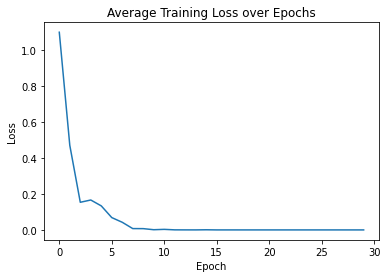

In [134]:
plt.plot([i for i in range(NUM_EPOCHS)], avg_loss)
plt.title('Average Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [136]:
_ = test(test_dl, fin_model, torch.nn.CrossEntropyLoss(), device)

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.000486 



In [150]:
from google.colab import files
import pickle
best_highly_var.to_pickle('./best_features.out')
files.download('./best_features.out')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [145]:
print(best_highly_var)

Xkr4              False
Gm37381           False
Rp1               False
Sox17              True
Gm37323           False
                  ...  
AC168977.2        False
AC168977.1        False
PISD              False
DHRSX             False
CAAA01147332.1    False
Name: highly_variable, Length: 19125, dtype: bool
